In [1]:
%load_ext autoreload
%autoreload 2

Number of samples: 1136


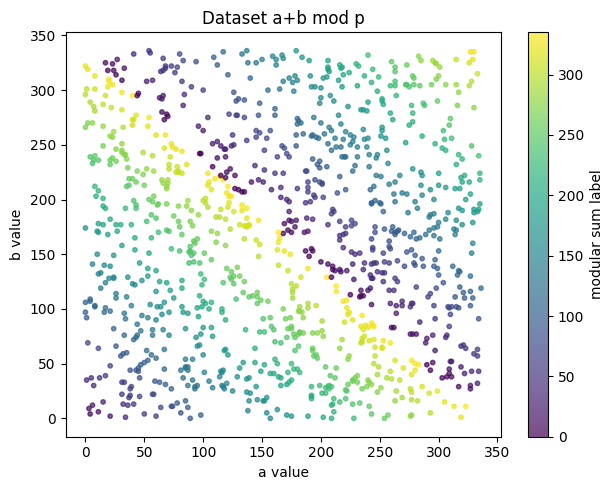

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from utils.config import MODELS_DIR
import os
from tasks.arithmetic.dataset import get_mod_arithmetic_cp_dataloaders, ArithmeticDatasetConfig
from tasks.arithmetic import visualize_data
from models.transformer import Transformer

device = t.device("cuda" if t.cuda.is_available() else "cpu")

config = ArithmeticDatasetConfig(
  p=337,
  noise_frac=0
)

train_dataloader, val_dataloader, _ = get_mod_arithmetic_cp_dataloaders(data_config=config, batch_size=256, val_frac=0.99)
visualize_data(train_dataloader)
data_iter = iter(train_dataloader)

In [3]:
from tasks.arithmetic.utils import load_model_and_dataset

checkpoint_dir = os.path.join(MODELS_DIR, 'arithmetic_transformer_baseline')

cp = load_model_and_dataset(Transformer, checkpoint_dir, checkpoint=1, device=device)

cp.val_loss

0.0018379448512051669

In [57]:
from models.other import MLP, MLPWithEmbedding
from models.transformer import Transformer
from models.transformer import Embedding

x, y_int, _ = next(iter(cp.dataloader))
x = x.to(device)
y_int = y_int.to(device)

model = MLPWithEmbedding(n_vocab=config.p+1, embed_dim=128, sequence_len=3, hidden_dims=[512, 512])
# model = Transformer(d_model=32, n_vocab=config.p+1, max_seq_len=3, n_heads=4, n_layers=1, d_mlp=128)
model.to(device)

print(x.shape)
pred = model(x)
pred = pred[:,-1]

criterion = nn.CrossEntropyLoss()

print(pred.shape, y_int.shape)
print(pred.dtype, y_int.dtype)
loss = criterion(pred, y_int)

model

torch.Size([512, 3])
torch.Size([512, 384])
torch.Size([512, 338]) torch.Size([512])
torch.float32 torch.int64


MLPWithEmbedding(
  (embedding): Embedding()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): MLP(
    (fc): Sequential(
      (0): Linear(in_features=384, out_features=1014, bias=True)
      (1): Identity()
      (2): ReLU()
    )
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(3, 338))
)

: 

In [ ]:
criterion = nn.CrossEntropyLoss()


print(x.shape, y.shape)
print(x.dtype, y.dtype)
loss = criterion(x,y)

loss

torch.Size([3, 4]) torch.Size([3])
torch.float32 torch.int64


tensor(0.7437, device='cuda:0')